In [1]:
import os
from google.cloud import bigquery
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import geodesic

import warnings
warnings.filterwarnings("ignore")


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:/Users/debna/downloads/festive-athlete-456507-a5-f01c54458dfd.json"
client = bigquery.Client()
query_april_2017 = """
SELECT *
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE EXTRACT(YEAR FROM starttime) = 2017 AND EXTRACT(MONTH FROM starttime) = 4
"""

query_april_2018 = """
SELECT *
FROM `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE EXTRACT(YEAR FROM starttime) = 2018 AND EXTRACT(MONTH FROM starttime) = 4
"""


### Data Loading

In [2]:
df_april_2017 = client.query(query_april_2017).to_dataframe()
df_april_2018 = client.query(query_april_2018).to_dataframe()

## Data Preparation

In [3]:
print(df_april_2017.isnull().sum())

tripduration                    0
starttime                       0
stoptime                        0
start_station_id                0
start_station_name              0
start_station_latitude          0
start_station_longitude         0
end_station_id                  0
end_station_name                0
end_station_latitude            0
end_station_longitude           0
bikeid                          0
usertype                        0
birth_year                 168672
gender                          0
customer_plan                   0
dtype: int64


In [4]:
df_april_2017[['birth_year']] = SimpleImputer(strategy='most_frequent').fit_transform(df_april_2017[['birth_year']])

In [5]:
print(df_april_2018.isnull().sum())

tripduration               0
starttime                  0
stoptime                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bikeid                     0
usertype                   0
birth_year                 0
gender                     0
customer_plan              0
dtype: int64


In [6]:
df_april_2017['starttime'] = pd.to_datetime(df_april_2017['starttime'])
df_april_2018['starttime'] = pd.to_datetime(df_april_2018['starttime'])

avg_duration_2017 = df_april_2017['tripduration'].mean()
avg_duration_2018 = df_april_2018['tripduration'].mean()

print(f"Average Trip Duration in April 2017: {avg_duration_2017} seconds")
print(f"Average Trip Duration in April 2018: {avg_duration_2018} seconds")

Average Trip Duration in April 2017: 1085.8632237700356 seconds
Average Trip Duration in April 2018: 970.9073223595706 seconds


In [7]:
num_trips_2017 = len(df_april_2017)
num_trips_2018 = len(df_april_2018)

print("April 2017 Trips:", num_trips_2017)
print("April 2018 Trips:", num_trips_2018)
print("Difference in no of trips:",num_trips_2017-num_trips_2018)

April 2017 Trips: 1315404
April 2018 Trips: 1307543
Difference in no of trips: 7861


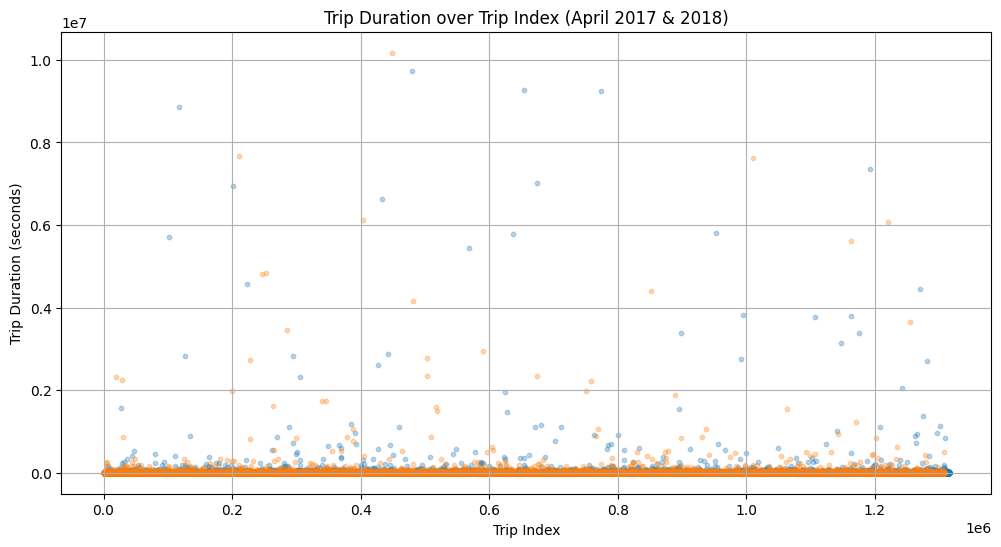

In [8]:
plt.figure(figsize=(12,6))
plt.scatter(df_april_2017.index, df_april_2017['tripduration'], alpha=0.3, s=10)
plt.scatter(df_april_2018.index, df_april_2018['tripduration'], alpha=0.3, s=10)
plt.title("Trip Duration over Trip Index (April 2017 & 2018)")
plt.xlabel("Trip Index")
plt.ylabel("Trip Duration (seconds)")
plt.grid(True)
plt.show()

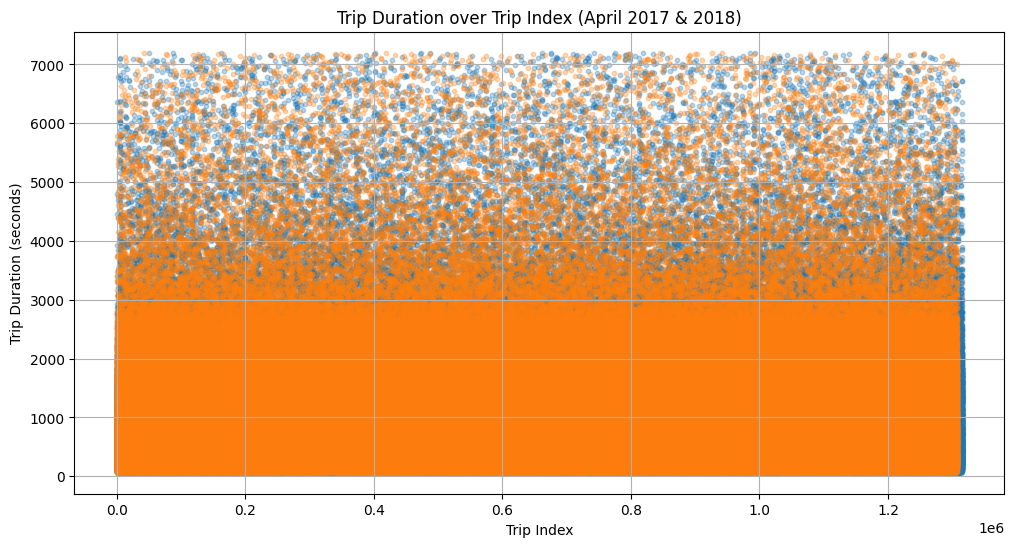

In [9]:
df_april_2017_filt = df_april_2017[(df_april_2017['tripduration'] >= 60) & (df_april_2017['tripduration'] <= 7200) & (df_april_2017['start_station_latitude'] <= 41.0)& (df_april_2017['end_station_latitude'] <= 41.0)]
df_april_2018_filt = df_april_2018[(df_april_2018['tripduration'] >= 60) & (df_april_2018['tripduration'] <= 7200)& (df_april_2018['start_station_latitude'] <= 41.0)& (df_april_2018['end_station_latitude'] <= 41.0)]

df_april_2017_filt['age'] = df_april_2017_filt['starttime'].dt.year - df_april_2017_filt['birth_year']
df_april_2018_filt['age'] = df_april_2018_filt['starttime'].dt.year - df_april_2018_filt['birth_year']

df_april_2017_filt['year'] = 2017
df_april_2018_filt['year'] = 2018

df_april_2017_filt['day_of_week'] = df_april_2017_filt['starttime'].dt.day_name()
df_april_2018_filt['day_of_week'] = df_april_2018_filt['starttime'].dt.day_name()

bins = [10, 20, 30, 60, 80, 100]
labels = ['10–19', '20–29', '30–59', '60–79', '80+']

df_april_2017_filt['age_group'] = pd.cut(df_april_2017_filt['age'], bins=bins, labels=labels, right=False)
df_april_2018_filt['age_group'] = pd.cut(df_april_2018_filt['age'], bins=bins, labels=labels, right=False)

combined = pd.concat([df_april_2017_filt, df_april_2018_filt])

plt.figure(figsize=(12,6))
plt.scatter(df_april_2017_filt.index, df_april_2017_filt['tripduration'], alpha=0.3, s=10)
plt.scatter(df_april_2018_filt.index, df_april_2018_filt['tripduration'], alpha=0.3, s=10)
plt.title("Trip Duration over Trip Index (April 2017 & 2018)")
plt.xlabel("Trip Index")
plt.ylabel("Trip Duration (seconds)")
plt.grid(True)
plt.show()

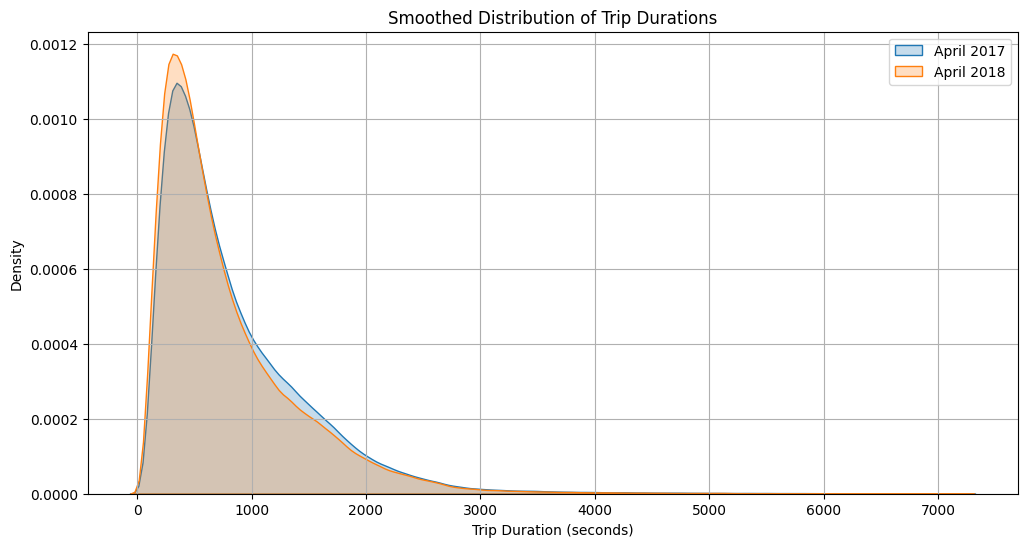

In [10]:
plt.figure(figsize=(12,6))
sns.kdeplot(df_april_2017_filt['tripduration'], label='April 2017', shade=True)
sns.kdeplot(df_april_2018_filt['tripduration'], label='April 2018', shade=True)
plt.title("Smoothed Distribution of Trip Durations")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [11]:

count_2017 = df_april_2017_filt['usertype'].value_counts()
count_2018 = df_april_2018_filt['usertype'].value_counts()

comparison_df = pd.DataFrame({
    'April 2017': count_2017,
    'April 2018': count_2018
}).fillna(0).astype(int)

print(comparison_df)


            April 2017  April 2018
usertype                          
Subscriber     1125079     1157158
Customer        184884      146194


# **H1 - More subscribers (commuters) than casual riders → shorter trips**

### Casual riders take longer trips than subscribers

## More subscribers than casual riders

            April 2017  April 2018  Change (%)
usertype                                      
Subscriber     1125079     1157158        2.85
Customer        184884      146194      -20.93


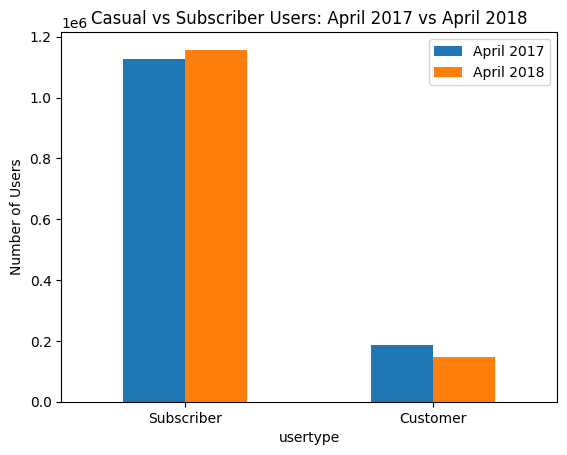

In [12]:
count_2017 = df_april_2017_filt['usertype'].value_counts()
count_2018 = df_april_2018_filt['usertype'].value_counts()


user_comparison = pd.DataFrame({
    'April 2017': count_2017,
    'April 2018': count_2018
}).fillna(0).astype(int)


user_comparison['Change (%)'] = ((user_comparison['April 2018'] - user_comparison['April 2017']) / user_comparison['April 2017'] * 100).round(2)
print(user_comparison)
user_comparison[['April 2017', 'April 2018']].plot(kind='bar')
plt.title('Casual vs Subscriber Users: April 2017 vs April 2018')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()

## Subscribers take shorter trips than casual riders

In [13]:
trip_stats_2017 = df_april_2017_filt.groupby('usertype')['tripduration'].agg(['count', 'mean', 'median']).round(2)
trip_stats_2018 = df_april_2018_filt.groupby('usertype')['tripduration'].agg(['count', 'mean', 'median']).round(2)

print("Trip Duration - April 2017:\n", trip_stats_2017)
print("\nTrip Duration - April 2018:\n", trip_stats_2018)


Trip Duration - April 2017:
               count     mean  median
usertype                            
Customer     184884  1486.69  1322.0
Subscriber  1125079   748.82   578.0

Trip Duration - April 2018:
               count     mean  median
usertype                            
Customer     146194  1491.14  1320.0
Subscriber  1157158   711.23   542.0


         April 2017  April 2018  Change (%)
gender                                     
female       286958      293086        2.14
male         853571      889041        4.16
unknown      169434      121225      -28.45


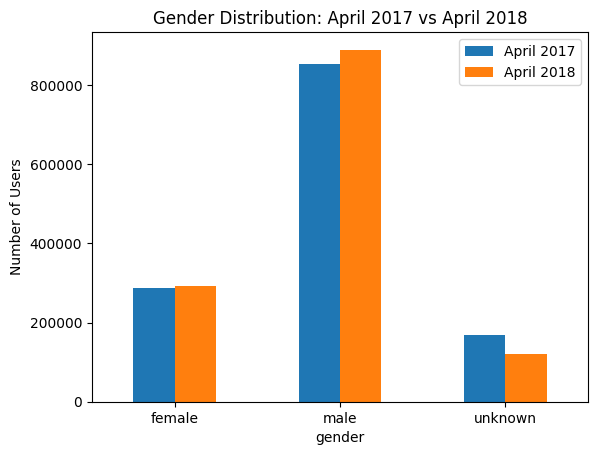

In [14]:
gender_2017 = df_april_2017_filt['gender'].value_counts().sort_index()
gender_2018 = df_april_2018_filt['gender'].value_counts().sort_index()


gender_comparison = pd.DataFrame({
    'April 2017': gender_2017,
    'April 2018': gender_2018
}).fillna(0).astype(int)


gender_comparison['Change (%)'] = ((gender_comparison['April 2018'] - gender_comparison['April 2017']) / gender_comparison['April 2017'] * 100).round(2)

print(gender_comparison)
gender_comparison[['April 2017', 'April 2018']].plot(kind='bar')
plt.title('Gender Distribution: April 2017 vs April 2018')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.show()


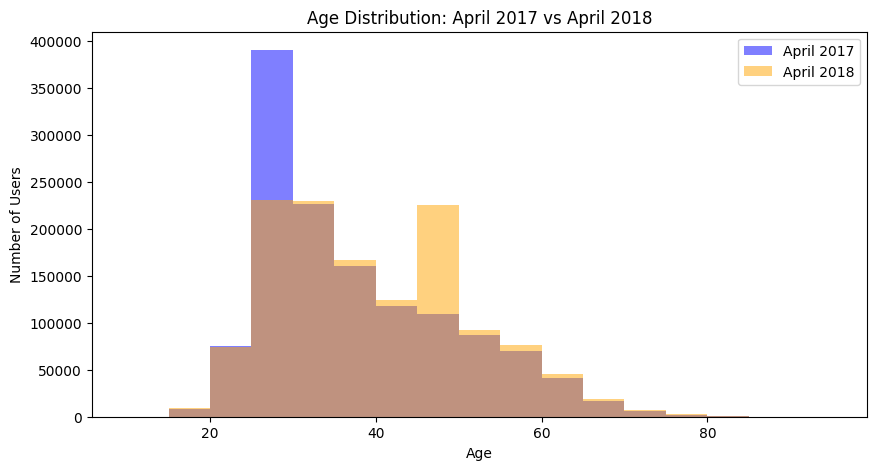

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(df_april_2017_filt['age'], bins=range(10, 100, 5), alpha=0.5, label='April 2017', color='blue')
plt.hist(df_april_2018_filt['age'], bins=range(10, 100, 5), alpha=0.5, label='April 2018', color='orange')
plt.title('Age Distribution: April 2017 vs April 2018')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.legend()
plt.show()


###  Interpretation
Younger groups (e.g., 18–24) may take longer trips if casual

Older commuter groups (35–54) may have shorter, routine trips

You might spot trends shifting from 2017 → 2018

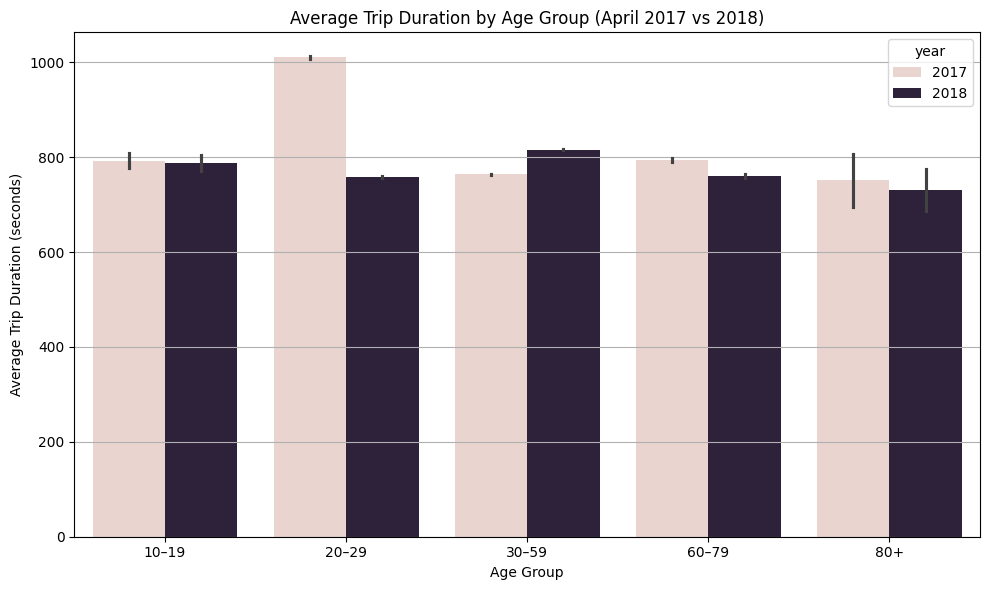

In [16]:
group_stats = combined.groupby(['year', 'age_group'])['tripduration'].describe()
plot_data = combined.dropna(subset=['age_group', 'tripduration'])
plot_data['tripduration'] = pd.to_numeric(plot_data['tripduration'], errors='coerce')
plot_data['age_group'] = plot_data['age_group'].astype(str)


plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x='age_group', y='tripduration', hue='year', order=labels)
plt.title('Average Trip Duration by Age Group (April 2017 vs 2018)')
plt.xlabel('Age Group')
plt.ylabel('Average Trip Duration (seconds)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()




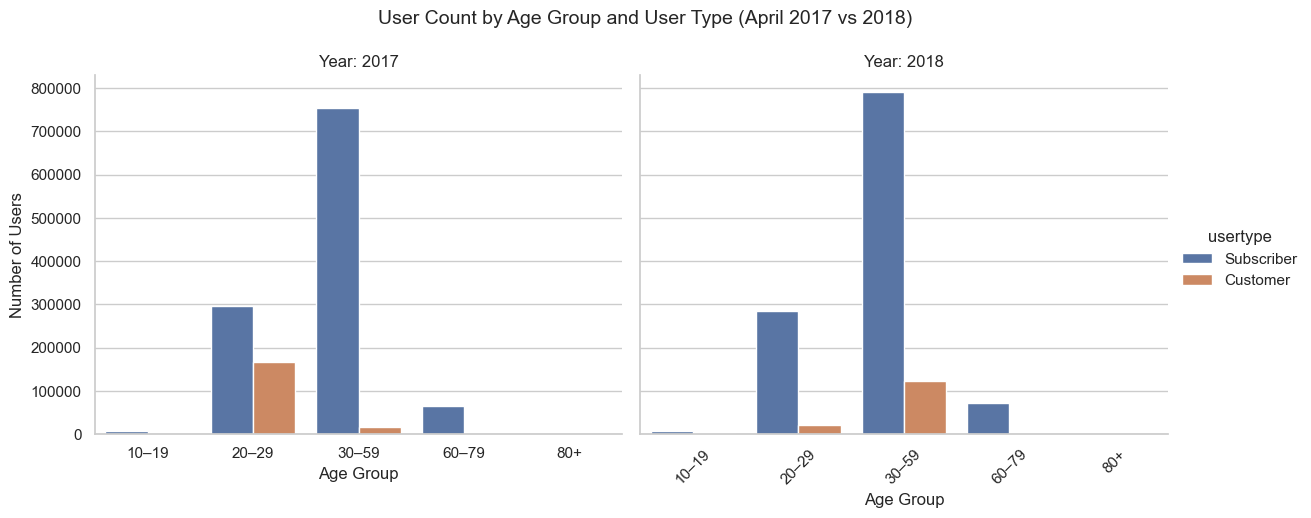

In [17]:
sns.set(style="whitegrid")
g = sns.catplot(
    data=plot_data,
    x='age_group',
    kind='count',
    hue='usertype',
    col='year',
    order=labels,
    height=5,
    aspect=1.2
)

g.set_axis_labels("Age Group", "Number of Users")
g.set_titles("Year: {col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("User Count by Age Group and User Type (April 2017 vs 2018)", fontsize=14)
plt.xticks(rotation=45)
plt.show()


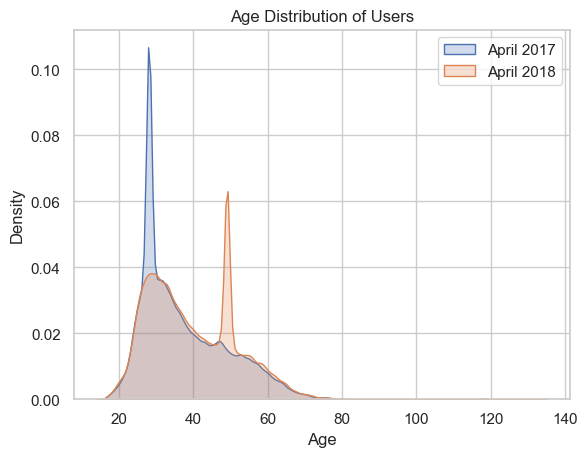

In [18]:
sns.kdeplot(df_april_2017_filt['age'], label='April 2017', fill=True)
sns.kdeplot(df_april_2018_filt['age'], label='April 2018', fill=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.legend()
plt.show()

# **H2-- The expansion of bike stations between April 2017 and April 2018 led to increased ridership and more evenly distributed usage across stations**

## Count unique stations

In [19]:
start_2017 = df_april_2017_filt['start_station_name'].nunique()
end_2017 = df_april_2017_filt['end_station_name'].nunique()

start_2018 = df_april_2018_filt['start_station_name'].nunique()
end_2018 = df_april_2018_filt['end_station_name'].nunique()

print(f"Start stations: 2017 = {start_2017}, 2018 = {start_2018}")
print(f"End stations: 2017 = {end_2017}, 2018 = {end_2018}")

Start stations: 2017 = 613, 2018 = 764
End stations: 2017 = 622, 2018 = 770


## Total rides comparison

In [20]:
print("Trips in April 2017:", len(df_april_2017_filt))
print("Trips in April 2018:", len(df_april_2018_filt))

Trips in April 2017: 1309963
Trips in April 2018: 1303352


## Distribution of station usage

In [21]:
top_start_2017 = df_april_2017_filt['start_station_name'].value_counts(normalize=True).head(100).sum()
top_start_2018 = df_april_2018_filt['start_station_name'].value_counts(normalize=True).head(100).sum()

print(f"Top 100 stations usage share in April 2017: {top_start_2017:.2%}")
print(f"Top 100 stations usage share in April 2018: {top_start_2018:.2%}")

Top 100 stations usage share in April 2017: 40.97%
Top 100 stations usage share in April 2018: 37.92%


In [22]:
def gini(array):
    array = np.array(array, dtype=np.float64)
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    array += 1e-7
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


start_gini_2017 = gini(df_april_2017_filt['start_station_name'].value_counts())
start_gini_2018 = gini(df_april_2018_filt['start_station_name'].value_counts())

end_gini_2017 = gini(df_april_2017_filt['end_station_name'].value_counts())
end_gini_2018 = gini(df_april_2018_filt['end_station_name'].value_counts())

print(f"Gini Coefficient start- April 2017: {start_gini_2017:.3f}")
print(f"Gini Coefficient start- April 2018: {start_gini_2018:.3f}")


print(f"Gini Coefficient start- April 2017: {end_gini_2017:.3f}")
print(f"Gini Coefficient start- April 2018: {end_gini_2018:.3f}")

Gini Coefficient start- April 2017: 0.453
Gini Coefficient start- April 2018: 0.484
Gini Coefficient start- April 2017: 0.462
Gini Coefficient start- April 2018: 0.491


# **H-- Trip duration patterns differ across age + gender, and those patterns changed from April 2017 to April 2018**

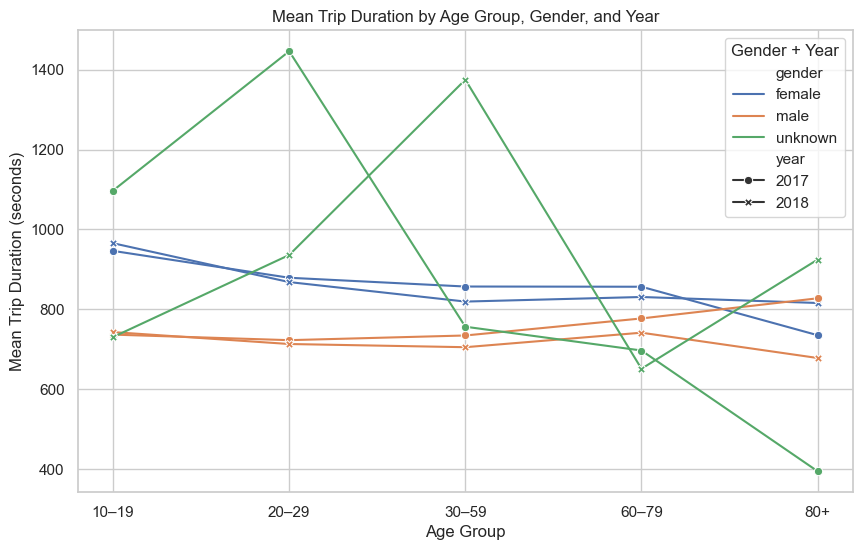

In [23]:
combined = pd.concat([df_april_2017_filt, df_april_2018_filt])

duration_summary = combined.groupby(['year', 'gender', 'age_group'])['tripduration'].agg(['count', 'mean', 'median']).reset_index()

duration_summary[['mean', 'median']] = duration_summary[['mean', 'median']].round(2)

plt.figure(figsize=(10, 6))
sns.lineplot(data=duration_summary, x='age_group', y='mean', hue='gender', style='year', markers=True, dashes=False)
plt.title('Mean Trip Duration by Age Group, Gender, and Year')
plt.ylabel('Mean Trip Duration (seconds)')
plt.xlabel('Age Group')
plt.legend(title='Gender + Year')
plt.grid(True)
plt.show()


# **H-- More Trips During Peak Hours**

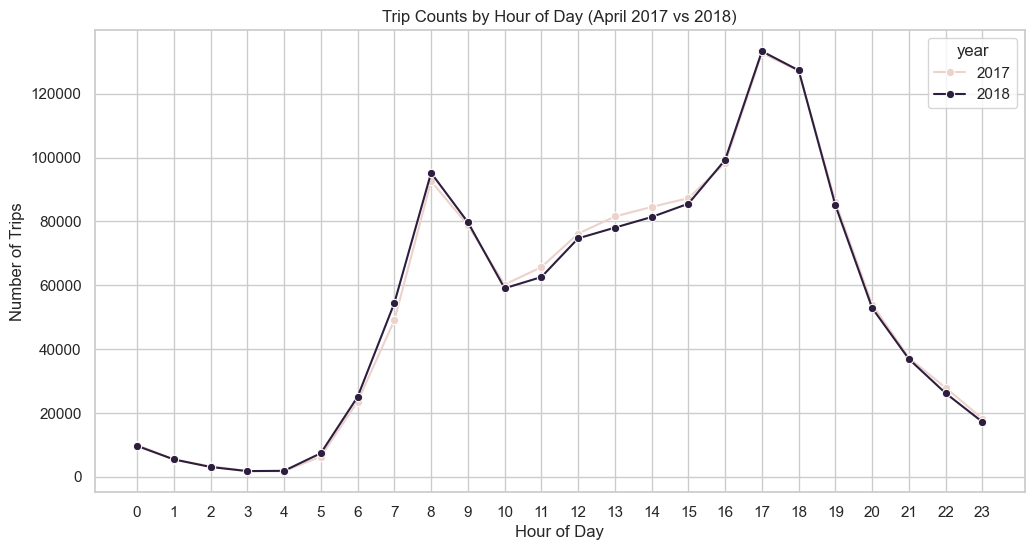

   year peak_hour  trip_count
0  2017  Off-Peak      584842
1  2017      Peak      725121
2  2018  Off-Peak      569813
3  2018      Peak      733539


In [24]:
df_april_2017_filt['hour'] = df_april_2017_filt['starttime'].dt.hour
df_april_2018_filt['hour'] = df_april_2018_filt['starttime'].dt.hour
combined = pd.concat([df_april_2017_filt, df_april_2018_filt])

hourly_counts = combined.groupby(['year', 'hour']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_counts, x='hour', y='trip_count', hue='year', marker='o')
plt.title('Trip Counts by Hour of Day (April 2017 vs 2018)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


def label_peak(hour):
    return 'Peak' if (7 <= hour <= 10) or (16 <= hour <= 19) else 'Off-Peak'

combined['peak_hour'] = combined['hour'].apply(label_peak)


peak_counts = combined.groupby(['year', 'peak_hour']).size().reset_index(name='trip_count')

print(peak_counts)


# H-- Station Density Increased

## Starting Station Density

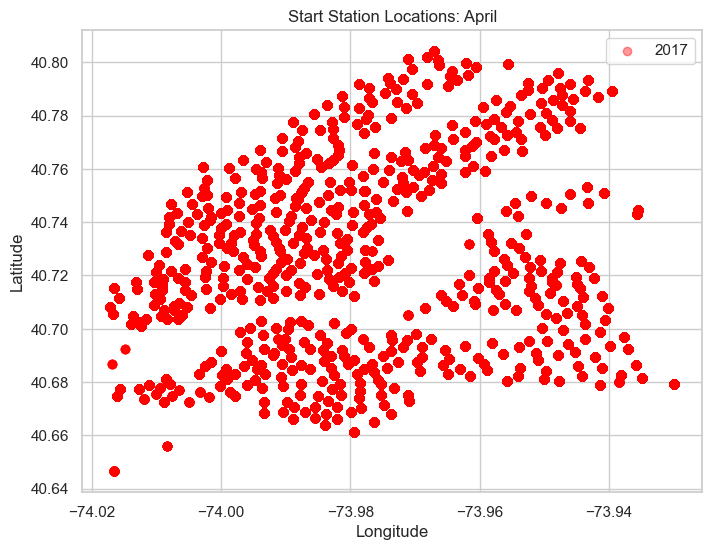

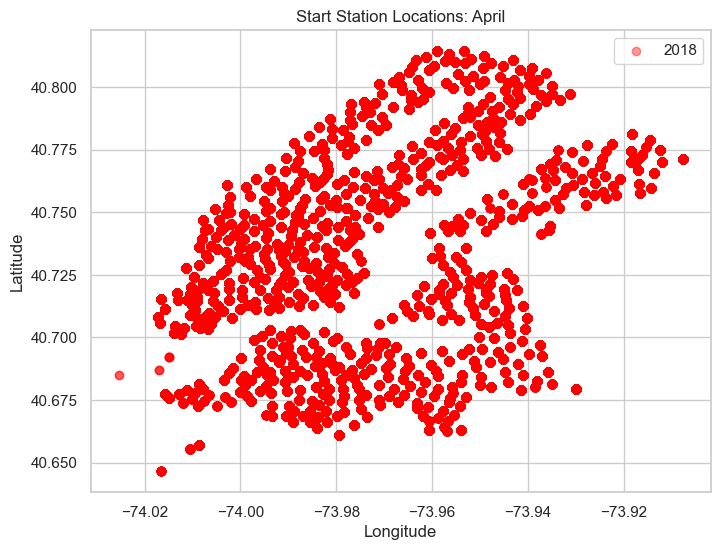

2017 Station Density: 4.75 stations/km²
2018 Station Density: 4.13 stations/km²
Density increased by -13.15%


In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(df_april_2017_filt['start_station_longitude'], df_april_2017_filt['start_station_latitude'], alpha=0.4, label='2017', c='red')
plt.title('Start Station Locations: April')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_april_2018_filt['start_station_longitude'], df_april_2018_filt['start_station_latitude'], alpha=0.4, label='2018', c='red')
plt.title('Start Station Locations: April')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

stations_2017 = df_april_2017_filt[['start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()
stations_2018 = df_april_2018_filt[['start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()



def bounding_box_area_km2(df):
    lat_min = df['start_station_latitude'].min()
    lat_max = df['start_station_latitude'].max()
    lon_min = df['start_station_longitude'].min()
    lon_max = df['start_station_longitude'].max()
    
   
    center_lat = (lat_min + lat_max) / 2
    width_km = geodesic((center_lat, lon_min), (center_lat, lon_max)).km
    
   
    height_km = geodesic((lat_min, lon_min), (lat_max, lon_min)).km
    
    return width_km * height_km

area_2017 = bounding_box_area_km2(stations_2017)
area_2018 = bounding_box_area_km2(stations_2018)

density_2017 = len(stations_2017) / area_2017
density_2018 = len(stations_2018) / area_2018

print(f"2017 Station Density: {density_2017:.2f} stations/km²")
print(f"2018 Station Density: {density_2018:.2f} stations/km²")

percent_change = ((density_2018 - density_2017) / density_2017) * 100
print(f"Density increased by {percent_change:.2f}%")


## Ending Station Density

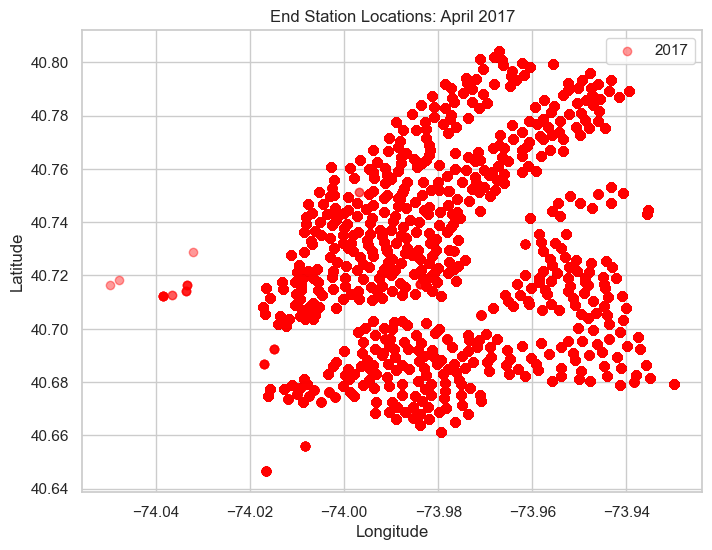

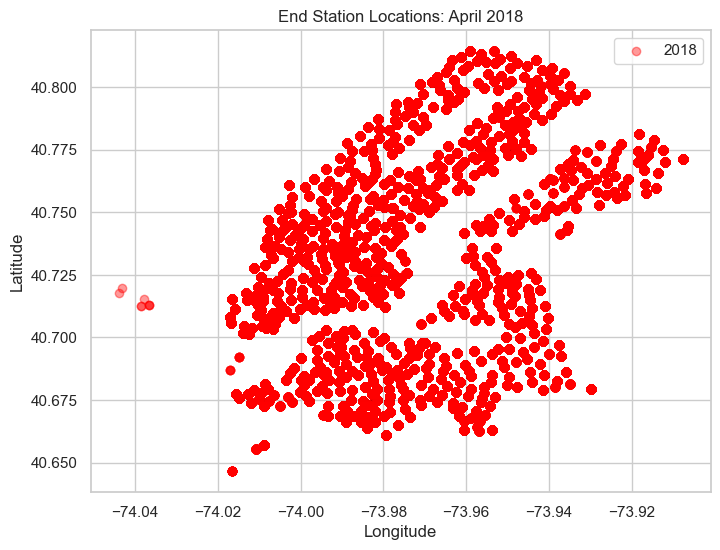

2017 Station Density: 3.51 stations/km²
2018 Station Density: 3.59 stations/km²
Density increased by 2.32%


In [26]:
list_of_df = [df_april_2017_filt, df_april_2018_filt]   
plt.figure(figsize=(8, 6))
plt.scatter(df_april_2017_filt['end_station_longitude'], df_april_2017_filt['end_station_latitude'], alpha=0.4, label='2017', c='red')
plt.title('End Station Locations: April 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_april_2018_filt['end_station_longitude'], df_april_2018_filt['end_station_latitude'], alpha=0.4, label='2018', c='red')
plt.title('End Station Locations: April 2018')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

stations_2017 = df_april_2017_filt[['end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates()
stations_2018 = df_april_2018_filt[['end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates()



def bounding_box_area_km2(df):
    lat_min = df['end_station_latitude'].min()
    lat_max = df['end_station_latitude'].max()
    lon_min = df['end_station_longitude'].min()
    lon_max = df['end_station_longitude'].max()
    
   
    center_lat = (lat_min + lat_max) / 2
    width_km = geodesic((center_lat, lon_min), (center_lat, lon_max)).km
    
   
    height_km = geodesic((lat_min, lon_min), (lat_max, lon_min)).km
    
    return width_km * height_km

area_2017 = bounding_box_area_km2(stations_2017)
area_2018 = bounding_box_area_km2(stations_2018)

density_2017 = len(stations_2017) / area_2017
density_2018 = len(stations_2018) / area_2018

print(f"2017 Station Density: {density_2017:.2f} stations/km²")
print(f"2018 Station Density: {density_2018:.2f} stations/km²")

percent_change = ((density_2018 - density_2017) / density_2017) * 100
print(f"Density increased by {percent_change:.2f}%")


# H-- Trip counts vary by day of the week

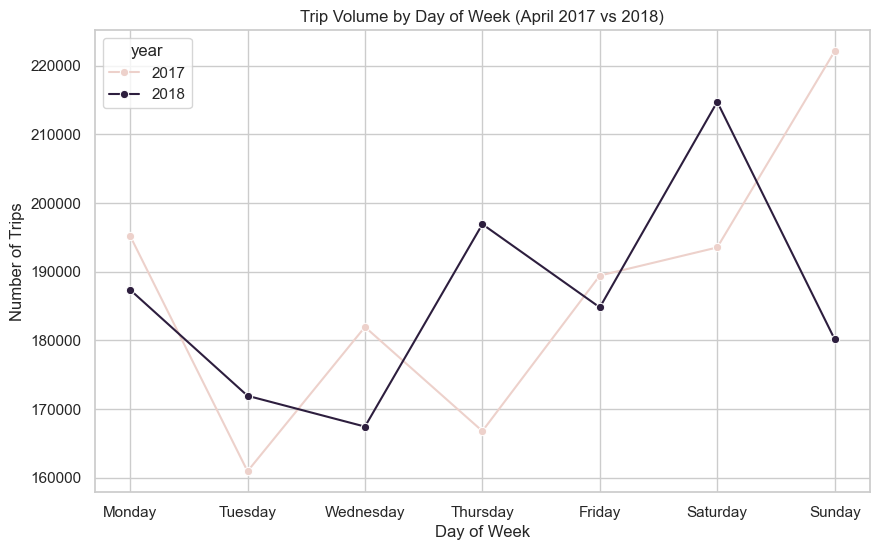

In [27]:
combined = pd.concat([df_april_2017_filt, df_april_2018_filt])
trip_counts = combined.groupby(['year', 'day_of_week']).size().reset_index(name='trip_count')

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trip_counts['day_of_week'] = pd.Categorical(trip_counts['day_of_week'], categories=days_order, ordered=True)
trip_counts = trip_counts.sort_values(['year', 'day_of_week'])


plt.figure(figsize=(10, 6))
sns.lineplot(data=trip_counts, x='day_of_week', y='trip_count', hue='year', marker='o')
plt.title('Trip Volume by Day of Week (April 2017 vs 2018)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

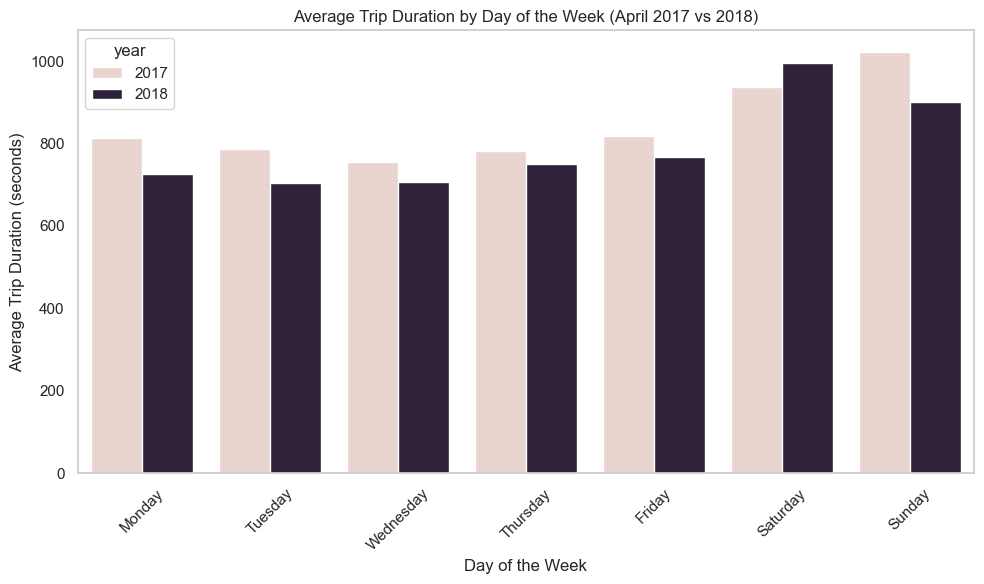

In [29]:
avg_trip_by_day = combined.groupby(['year', 'day_of_week'])['tripduration'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_trip_by_day, x='day_of_week', y='tripduration', hue='year', order=days_order)
plt.title('Average Trip Duration by Day of the Week (April 2017 vs 2018)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Trip Duration (seconds)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


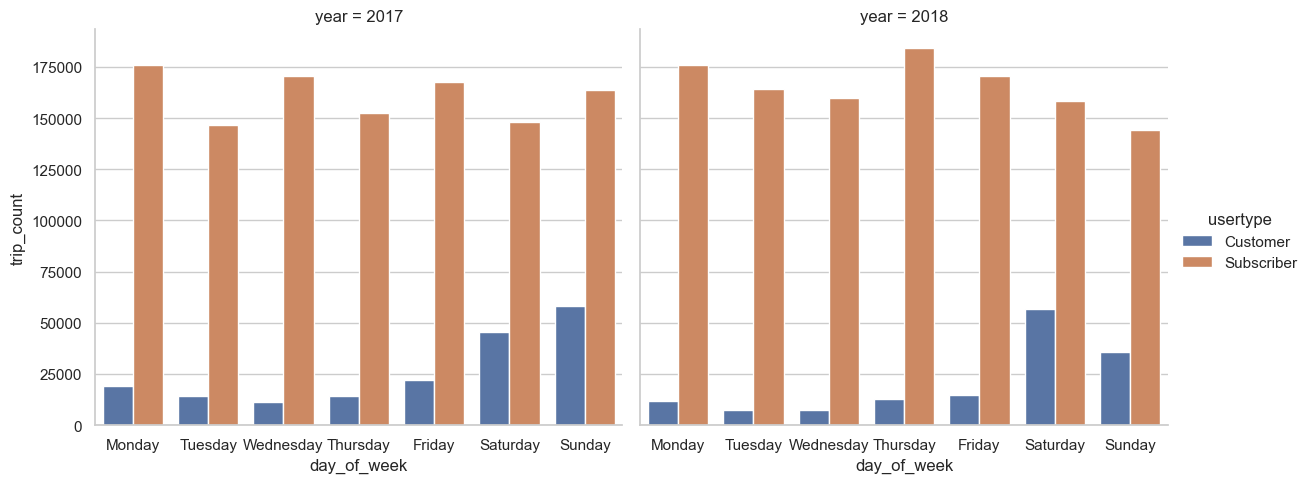

In [ ]:
trip_by_day_type = combined.groupby(['year', 'usertype', 'day_of_week']).size().reset_index(name='trip_count')

sns.catplot(data=trip_by_day_type, x='day_of_week', y='trip_count', hue='usertype', col='year',
            kind='bar', height=5, aspect=1.2, order=days_order)
plt.show()

# Bikes with Lower Mean Trip Duration

In [30]:
bike_means = combined.groupby('bikeid')['tripduration'].mean().reset_index()
bike_means.rename(columns={'tripduration': 'mean_tripduration'}, inplace=True)

# threshold = bike_means['mean_tripduration'].quantile(0.10)
low_duration_bikes = bike_means[bike_means['mean_tripduration'] <= 970]

In [31]:
(low_duration_bikes.sort_values('mean_tripduration')).to_csv('list of bikes with lower Trip Duration.csv')